In [2]:
from datasets import load_dataset
import huggingface_hub
import matplotlib.pyplot as plt
import numpy as np
import spacy
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from nltk.probability import FreqDist

c:\Users\Mena Lerf\anaconda3\envs\nlp\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Project Task 1: Data Exploration and Processing

#### Explore dataset

##### Functions

In [3]:
def plot_classes_distribution(labels, num_samples_per_class):
    plt.rcParams['figure.figsize'] = [10, 10]
    plt.barh(labels, num_samples_per_class)
    plt.xlabel("Number of samples")
    plt.ylabel("Class")
    plt.title("Distribution of the classes")
    plt.gca().invert_yaxis()  
    plt.tight_layout()
    plt.show()

In [4]:
def calculate_text_lengths():
    lengths = [len(sample) for sample in dataset['train']['text']]

    # Calculate statistics
    min_length = min(lengths)
    avg_length = np.round(np.mean(lengths), 2)
    std_length = np.round(np.std(lengths), 2)
    max_length = max(lengths)

    # Create a histogram with more bins and a logarithmic scale
    plt.rcParams['figure.figsize'] = [12, 6]
    plt.hist(lengths, bins=50, log=True, color='skyblue', alpha=0.7)

    # Add vertical lines for min, avg, and max lengths
    plt.axvline(min_length, color='r', linestyle='--', label=f'Min: {min_length}')
    plt.axvline(avg_length, color='g', linestyle='--', label=f'Avg: {avg_length}')
    plt.axvline(max_length, color='b', linestyle='--', label=f'Max: {max_length}')

    # Label the axes and add a title
    plt.xlabel("Length")
    plt.ylabel("Frequency (log scale)")
    plt.title("Distribution of Text Lengths")

    # Add a legend
    plt.legend()

    # Show standard deviation with a shaded region
    plt.fill_betweenx([0, 1], avg_length - std_length, avg_length + std_length, color='yellow', alpha=0.5, label=f'Std: {std_length}')

    # Adjust layout for better spacing
    plt.tight_layout()

    # Display the plot
    plt.show()

##### Task

In [5]:
dataset = load_dataset("argilla/medical-domain")

In [6]:
# Calculate basic statistics
# Number of samples, number of classes, number of samples per class
# Number of samples
num_samples = len(dataset['train'])
print("Number of samples: ", num_samples)

# Number of classes
labels = []
for sample in dataset['train']['prediction']:
    label = sample[0]['label']
    if label not in labels:
        labels.append(label)

num_classes = len(labels)
print("Number of classes: ", num_classes)

Number of samples:  4966
Number of classes:  40


In [7]:
# Number of samples per class
num_samples_per_class = []
for label in labels:
    num_samples_per_class.append(len(dataset['train'].filter(lambda example: example['prediction'][0]['label'] == label)))

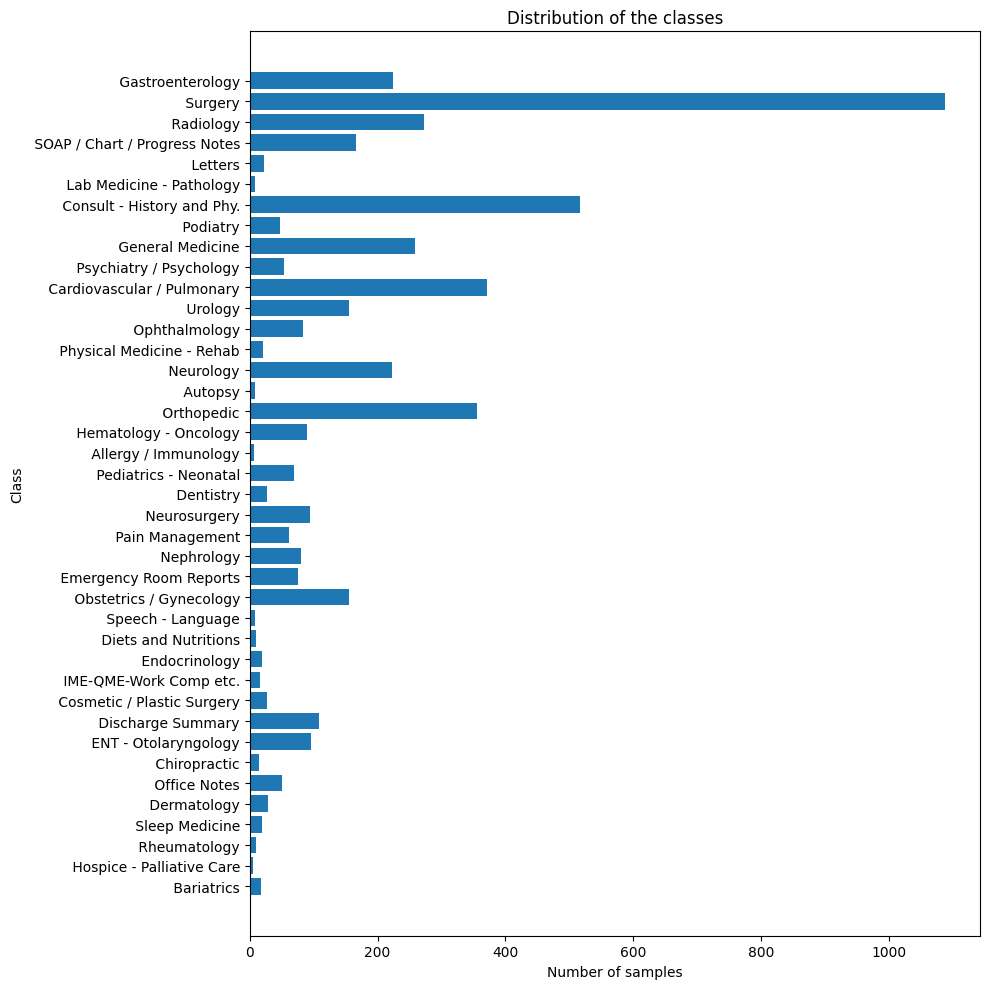

In [8]:
# plot the distribution of the classes
plot_classes_distribution(labels, num_samples_per_class)

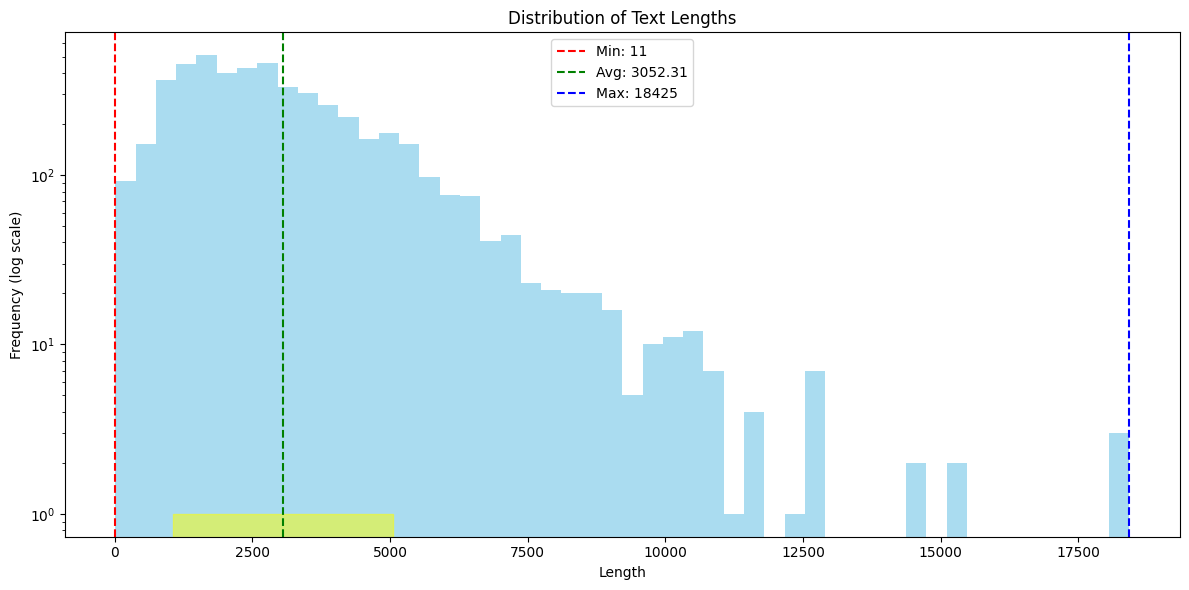

In [9]:
# Calculate text lengths
calculate_text_lengths()

In [10]:
from langdetect import detect
# Load the English language model
nlp = spacy.load("en_core_web_sm")

# Extract the detected language(s) for each text in the dataset
for text in dataset['train']['text']:
    # Use langdetect to detect the language of the text
    detected_language = detect(text)
    
print(f"Detected language in the text: {set(detected_language)}")

Detected language in the text: {'e', 'n'}


#### Processing pipeline with steps for reading the dataset, tokenizing, normalizing and token filtering

[nltk_data] Downloading package wordnet to C:\Users\Mena
[nltk_data]     Lerf\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


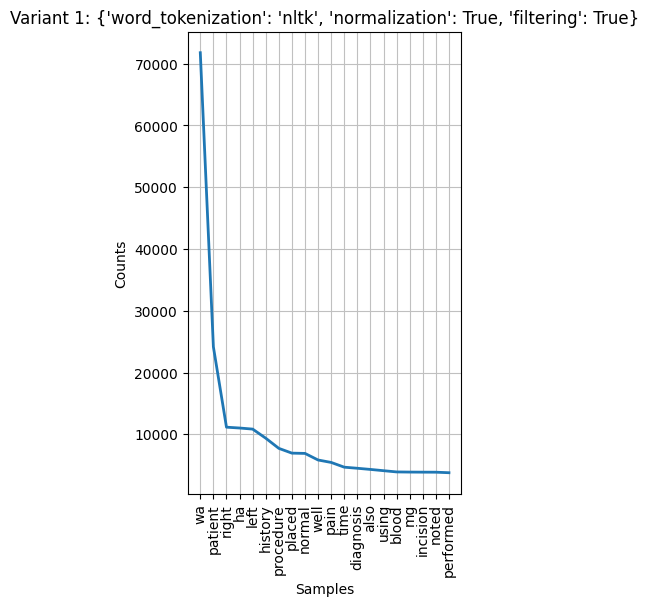

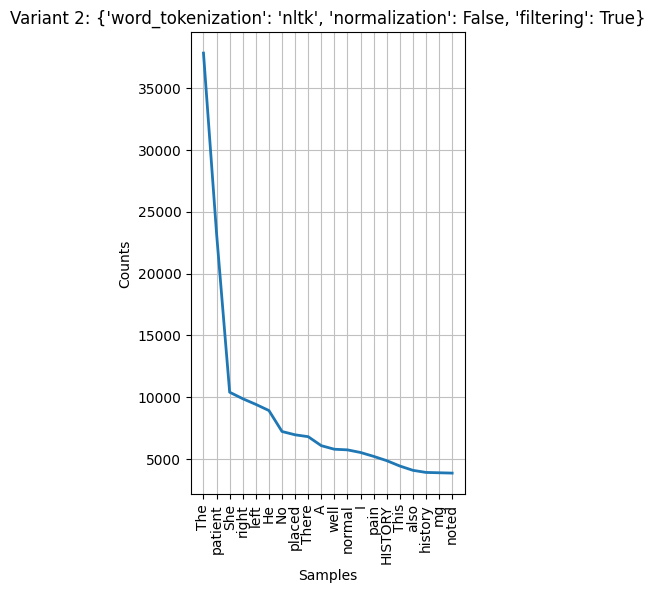

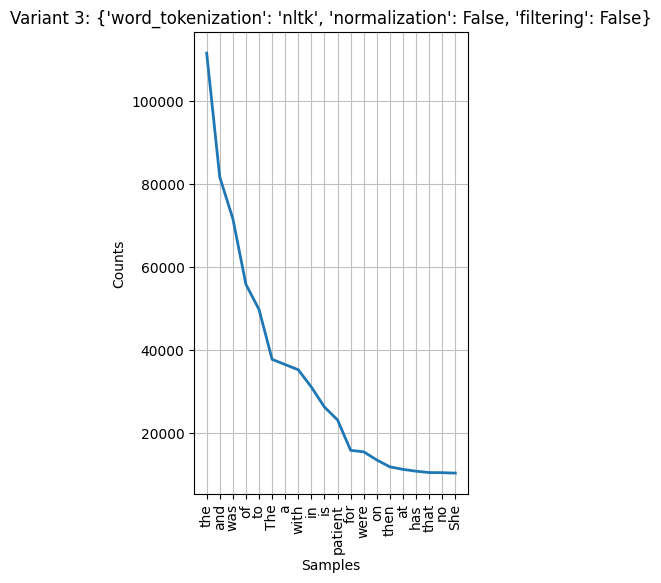

<Figure size 1200x600 with 0 Axes>

In [11]:
import spacy
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
import matplotlib.pyplot as plt

nltk.download('wordnet')


# Load the English language model for spaCy
nlp = spacy.load("en_core_web_sm")

# Define a function for text processing
def process_text(text, sentence_tokenization='spacy', word_tokenization='nltk', normalization=True, filtering=True):
    # Word tokenization using NLTK
    if word_tokenization == 'nltk':
        tokens = word_tokenize(text)

    # Normalization (lowercasing and lemmatization) using NLTK
    if normalization:
        tokens = [token.lower() for token in tokens]
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Token filtering (stopwords removal) using NLTK
    if filtering:
        stop_words = set(stopwords.words('english'))
        tokens = [token for token in tokens if token not in stop_words]

    # Remove punctuation tokens
    tokens = [token for token in tokens if token.isalpha()]

    return tokens

# Load your dataset (assuming you have it loaded as 'dataset')

# Define the text processing variants
variants = [
    {'word_tokenization': 'nltk', 'normalization': True, 'filtering': True},
    {'word_tokenization': 'nltk', 'normalization': False, 'filtering': True},
    {'word_tokenization': 'nltk', 'normalization': False, 'filtering': False},
]

# Calculate TFDs for each processing variant
tfd_results = []
for variant in variants:
    term_frequencies = FreqDist()

    for sample in dataset['train']:
        text = sample['text']
        tokens = process_text(text, **variant)
        term_frequencies.update(tokens)

    tfd_results.append((variant, term_frequencies))

# Visualize the TFD using a plot
plt.figure(figsize=(12, 6))

for i, (variant, tfd) in enumerate(tfd_results):
    plt.subplot(1, len(variants), i + 1)
    plt.title(f"Variant {i + 1}: {variant}")
    tfd.plot(20, cumulative=False)

plt.tight_layout()
plt.show()



Observation: <br>
 we can  see that some words get lemmatized to something non meaningful, such as the most frequent word "wa" which is the lemmatized form of "was". This is because the lemmatizer is not aware of the context of the word, and therefore lemmatizes it to something non meaningful. The same holds true for the word "ha" which is the lemmatized form of "has".

#### Are there differences per class?

In [22]:
#calculate tdf per class and plot in a single meaningful plot
freq_per_class = []
for label in labels:
    term_frequencies = FreqDist()
    for sample in dataset['train'].filter(lambda example: example['prediction'][0]['label'] == label):
        text = sample['text']
        tokens = process_text(text)
        term_frequencies.update(tokens)

    freq_per_class.append((label, term_frequencies.most_common(10)))
    print(f"Term frequencies for class {label}: {term_frequencies.most_common(10)}")


    


Term frequencies for class  Gastroenterology: [('wa', 2941), ('patient', 968), ('procedure', 481), ('history', 338), ('ha', 305), ('normal', 302), ('placed', 296), ('diagnosis', 258), ('abdomen', 227), ('colon', 225)]
Term frequencies for class  Surgery: [('wa', 26131), ('patient', 5339), ('procedure', 3323), ('right', 3194), ('left', 3183), ('placed', 3004), ('incision', 1776), ('using', 1754), ('diagnosis', 1664), ('anesthesia', 1616)]
Term frequencies for class  Radiology: [('wa', 1289), ('left', 664), ('right', 613), ('normal', 589), ('patient', 358), ('exam', 298), ('mild', 231), ('finding', 218), ('without', 193), ('image', 192)]
Term frequencies for class  SOAP / Chart / Progress Notes: [('ha', 641), ('patient', 580), ('wa', 545), ('mg', 291), ('history', 249), ('pain', 225), ('blood', 193), ('time', 188), ('well', 186), ('today', 164)]
Term frequencies for class  Letters: [('wa', 193), ('ha', 89), ('pain', 74), ('abc', 73), ('patient', 67), ('normal', 52), ('back', 48), ('histo

In [26]:
from collections import defaultdict

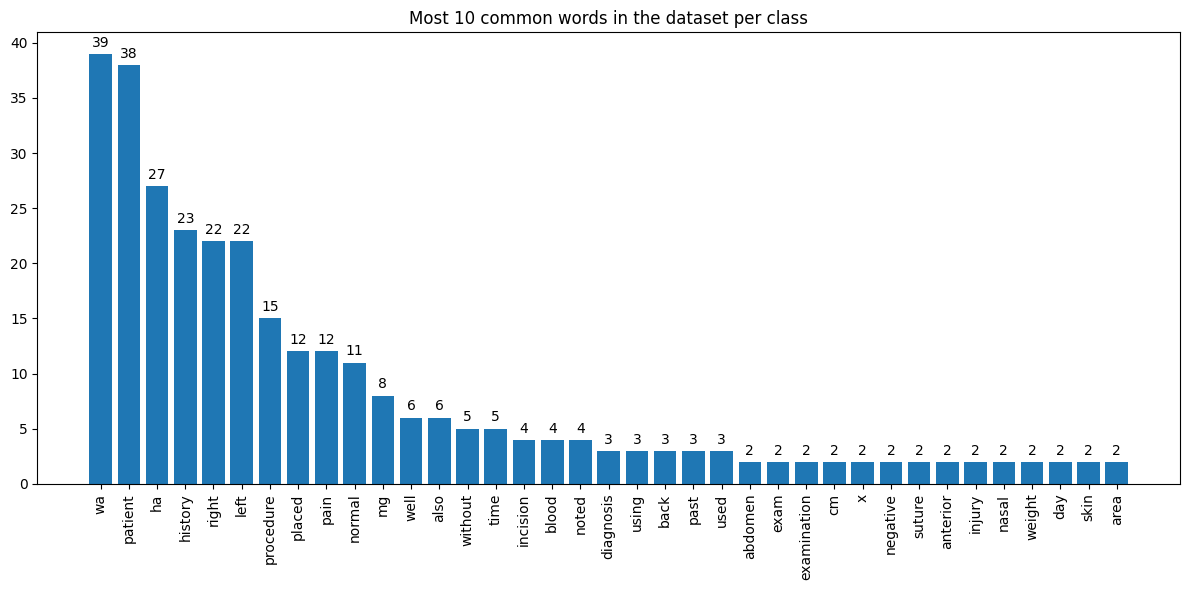

In [35]:
count_most_common = defaultdict(int)
for i, (label, tfd) in enumerate(freq_per_class):
    for word, freq in tfd:
        count_most_common[word] += 1
        
   
# only keep the ones who are in the most common list more than once
count_most_common = {k: v for k, v in count_most_common.items() if v > 1}

#sort by frequency
count_most_common = dict(sorted(count_most_common.items(), key=lambda item: item[1], reverse=True))

# Visualize the TFD using a plot and add occurence on bars
plt.figure(figsize=(12, 6))
plt.title(f"Most 10 common words in the dataset per class")
bars =plt.bar(count_most_common.keys(), count_most_common.values())
plt.bar_label(bars, padding=3)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()




there are some difference per class, however the most common terms are comparted by all classes. Others are more specific, probably per topic (eg abdomen or blood). Here, only the top 10 terms per class are considered, leaving out the ones that are only common in 1 class. (for better visualization)